In [1]:
import math
import collections
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
# define annuity
# define real estate market development
# define stock market development
# define currency exchange rate development

In [3]:
Payment = collections.namedtuple('Payment', ['fee', 'interest_amount', 'capital_downpayment_amount'])

class Mortgage:
    def __init__(self, service_fee, interest_rate, mortgage_amount, maturity, n_periods=12):
        self.service_fee = service_fee
        self.interest_rate = interest_rate
        self.mortgage_amount = mortgage_amount
        self.maturity = maturity
        self.n_periods = n_periods
        self.remaining_periods = maturity * n_periods
        self.annuity_factor = self.get_annuity_factor()
        self.monthly_payment = self.get_monthly_payment()
    
    def get_annuity_factor(self):
        interest_rate_amount_increase = (math.pow((1 + self.interest_rate
                                                   / self.n_periods),
                                                  self.remaining_periods))
        annuity_factor = ((interest_rate_amount_increase - 1)
                          / ((self.interest_rate/self.n_periods)
                             * interest_rate_amount_increase))
        return annuity_factor

    def get_monthly_payment(self):
        self.annuity_factor = self.get_annuity_factor()
        return self.mortgage_amount / self.annuity_factor
    
    def get_interest_amount(self):
        return self.mortgage_amount * (self.interest_rate / self.n_periods)

    def get_capital_downpayment(self):
        interest_amount = self.get_interest_amount()
        return self.monthly_payment - interest_amount
    
    def update_interest_rate(self, new_interest_rate):
        self.interest_rate = new_interest_rate
        self.annuity_factor = self.get_annuity_factor()
        new_monthly_payment = self.get_monthly_payment()
        self.update_monthly_payment_amount(new_monthly_payment)
        return self
    
    def update_monthly_payment_amount(self, new_monthly_payment):
        self.monthly_payment = new_monthly_payment
        return self

    def update_service_fee(self, new_service_fee):
        self.service_fee = new_service_fee
        return self
    
    def get_next_payment(self):
        interest_amount = self.get_interest_amount()
        capital_downpayment_amount = self.get_capital_downpayment()
        payment = Payment(self.service_fee, interest_amount, capital_downpayment_amount)
        self.remaining_periods -= 1
        self.mortgage_amount -= capital_downpayment_amount
        return payment

In [4]:
# add a method to the Mortgage that yields a payment named tuple (fee, interest, capital_downpayment)
# use the Mortgage class in another wrapper that updates the interest, the fee and runs through the payment plan

In [5]:
mort = Mortgage(20, 0.0268, int(1e6), 30, 12)

In [6]:
i = 0
hist = []
payments = []
while mort.mortgage_amount > 0 and i < int(1e4):
    if i == 3:
        mort.update_interest_rate(0.0305)
    if i == 60:
        mort.service_fee = 100
    if i == 12:
        mort.update_monthly_payment_amount(20000)
    clear_output()
    print(mort.mortgage_amount, i)
    hist.append(mort.mortgage_amount)
    payments.append(mort.get_next_payment())
    i += 1

6757.539351563504 64


In [7]:
df = pd.DataFrame(payments)
df['remaining_amount'] = hist
df['monthly_payment'] = df.interest_amount + df.capital_downpayment_amount + df.fee

In [8]:
df.head(15)

,fee,interest_amount,capital_downpayment_amount,remaining_amount,monthly_payment
0,20,2233.333333,1812.095880,1000000.000000,4065.429213
1,20,2229.286319,1816.142894,998187.904120,4065.429213
2,20,2225.230267,1820.198946,996371.761227,4065.429213
3,20,2527.818554,1713.822936,994551.562281,4261.641491
4,20,2523.462587,1718.178903,992837.739344,4261.641491
5,20,2519.095549,1722.545941,991119.560441,4261.641491
6,20,2514.717412,1726.924079,989397.014500,4261.641491
7,20,2510.328146,1731.313344,987670.090421,4261.641491
8,20,2505.927725,1735.713765,985938.777077,4261.641491
9,20,2501.516119,1740.125371,984203.063312,4261.641491


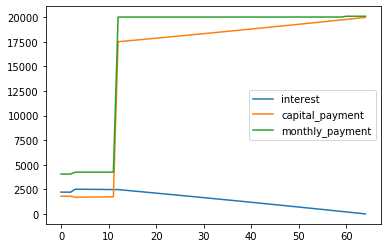

In [9]:
plt.plot(df.interest_amount, label='interest')
plt.plot(df.capital_downpayment_amount, label='capital_payment')
plt.plot(df.monthly_payment, label='monthly_payment')
plt.legend()
plt.show()

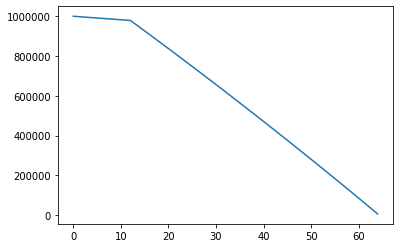

In [10]:
plt.plot(df.remaining_amount)
plt.show()